# Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History, Callback
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate,LeakyReLU

np.random.seed(2024)

In [2]:
dfs = []
labels = []
pdf = pd.DataFrame()
for company in ['AAPL', 'AMD', 'AMZN', 'ASML','CSCO', 'GOOGL', 'INTC', 'MSFT', 'NVDA']:
    df_numerical = pd.read_csv('../dataset_transcript/EPS/'+company+'_EPS.csv')
    df_textural = pd.read_csv('../dataset_transcript/Transcripts/'+company+'_sentiment.csv')
    df_result = pd.read_csv('../dataset_transcript/Stock Values and Sector Index/'+company+'.csv')
    df_numerical['Date'] = pd.to_datetime(df_numerical['Date'])
    df_textural['Date'] = pd.to_datetime(df_textural['Date'])
    df_result['Date'] = pd.to_datetime(df_result['Date'])

    df_combined = pd.merge(df_textural, df_numerical, how="left", on=["Date"])

    mask = df_result['Date'].isin(df_combined['Date'])
    indices_of_interest = df_result.index[mask]
    
    previous_indices = indices_of_interest - 1
    previous_indices = previous_indices[previous_indices >= 0]
    df_previous = df_result.iloc[previous_indices].copy().reset_index(drop=True)
    df_previous = df_previous.rename(columns={col: 'prev_' + col for col in df_previous.columns})
    df_previous['Date'] = df_result.iloc[indices_of_interest].reset_index(drop=True)['Date']
    
    df_combined = pd.merge(df_combined, df_previous, how="left", on=["Date"])
    df_combined.fillna(0, inplace = True) 

    df_result = pd.merge(df_result, df_combined['Date'], how='right', on=["Date"])
    df_combined=df_combined.drop(columns=['Fiscal Quarter End', 'Date', 'prev_Date'])
    pdf=df_combined
    dfs.append(df_combined)
    labels.append(df_result['Close'])
print(labels[0].shape)
dfs[0].shape

(19,)


(19, 21)

In [3]:
train_length, test_length, total_length = 14, 5, 19
n_epochs = 10000

In [4]:
class CustomPrintCallback(Callback):
    def __init__(self, print_every=1):
        self.print_every = print_every  # Define how often to print

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every == 0:  # Check if it's time to print
            print(f'Epoch {epoch + 1}: Loss = {logs["loss"]:.4f}')

def binary_accuracy(predict, truth):
    diff1 = predict[1:]-truth[:-1]
    y_prediction = diff1 / np.abs(diff1)
    diff2 = np.array(truth[1:])-np.array(truth[:-1])
    truth_labels = diff2/ np.abs(diff2)

    negative = -1.0
    positive = 1.0

    tp = np.sum(np.logical_and(y_prediction == positive, truth_labels == positive))
    tn = np.sum(np.logical_and(y_prediction == negative, truth_labels == negative))
    fp = np.sum(np.logical_and(y_prediction == positive, truth_labels == negative))
    fn = np.sum(np.logical_and(y_prediction == negative, truth_labels == positive))
    s = tp+tn+fp+fn
    return tp/s, tn/s, fp/s, fn/s

def show_test_performance(test_predictions, test_labels, company):
    tp, tn, fp, fn = binary_accuracy(test_predictions[train_length-1:], test_labels[train_length-1:])
    print("true increase: {:.0%}\ntrue decrease: {:.0%}\nfalse increase: {:.0%}\nfalse decrease: {:.0%}\n".format(tp, tn, fp, fn))

    # Plot the actual and predicted values
    x = np.arange(total_length)
    mask = (x >= train_length)
    plt.scatter(x[mask], test_predictions[mask], label='Predicted Testing Labels', c='lightpink')

    plt.plot(test_labels.tolist(), marker='x', label='Actual Testing Labels', c='skyblue')
    plt.title('Performance on '+company+' stock')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    return tp, tn, fp, fn

In [5]:
# create & clear model path
path = "model"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

files = glob.glob('model/*')
for f in files:
    os.remove(f)

sample  0 :  AAPL


/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Epoch 2000: Loss = 460.3966
Epoch 4000: Loss = 427.7305
Epoch 6000: Loss = 427.6011
Epoch 8000: Loss = 429.4408
Epoch 10000: Loss = 432.7480
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 197.7668
Test Loss: 197.76683044433594
true increase: 40%
true decrease: 40%
false increase: 0%
false decrease: 20%



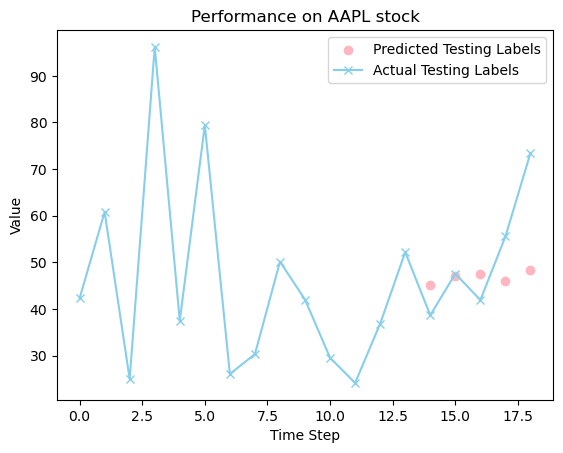

sample  1 :  AMD


/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 0 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Epoch 2000: Loss = 363.7546
Epoch 4000: Loss = 364.3677
Epoch 6000: Loss = 364.4261
Epoch 8000: Loss = 365.3105
Epoch 10000: Loss = 363.8154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 247.4881
Test Loss: 247.48812866210938
true increase: 60%
true decrease: 20%
false increase: 20%
false decrease: 0%



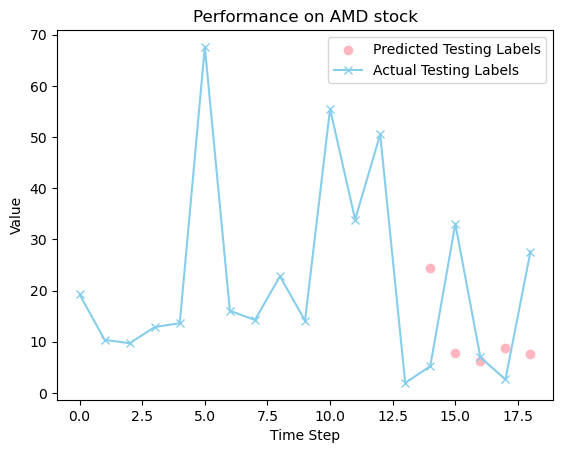

sample  2 :  AMZN
Epoch 2000: Loss = 391706.9375
Epoch 4000: Loss = 353970.2188
Epoch 6000: Loss = 337477.7812
Epoch 8000: Loss = 334073.4688
Epoch 10000: Loss = 334162.8438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 324014.3125
Test Loss: 324014.3125
true increase: 0%
true decrease: 40%
false increase: 20%
false decrease: 40%



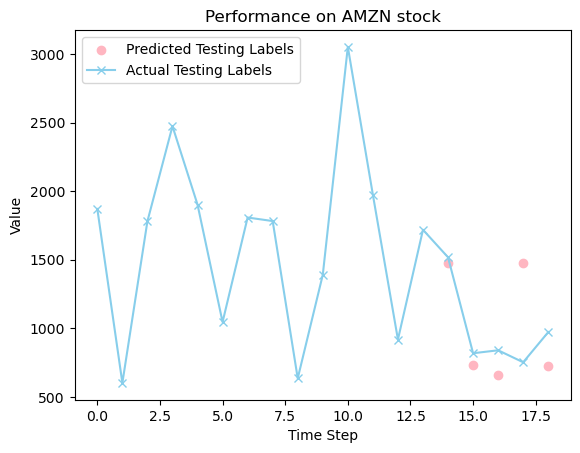

sample  3 :  ASML
Epoch 2000: Loss = 5190.5815
Epoch 4000: Loss = 3630.8940
Epoch 6000: Loss = 4309.6479
Epoch 8000: Loss = 4172.0962
Epoch 10000: Loss = 4236.9878
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 3199.7017
Test Loss: 3199.70166015625
true increase: 0%
true decrease: 60%
false increase: 0%
false decrease: 40%



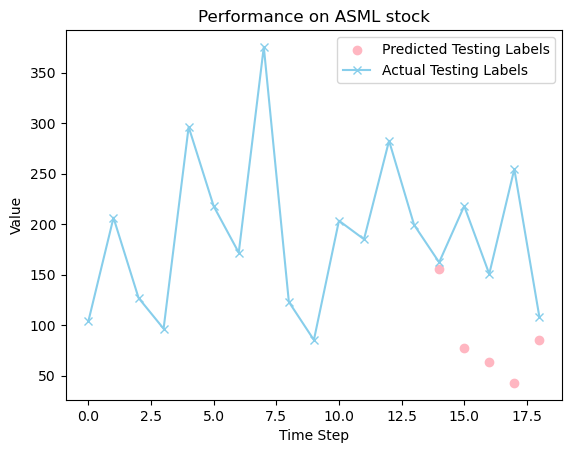

sample  4 :  CSCO
Epoch 2000: Loss = 107.8313
Epoch 4000: Loss = 90.0241
Epoch 6000: Loss = 91.0709
Epoch 8000: Loss = 91.3672
Epoch 10000: Loss = 90.7151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 41.0491
Test Loss: 41.04912567138672
true increase: 60%
true decrease: 40%
false increase: 0%
false decrease: 0%



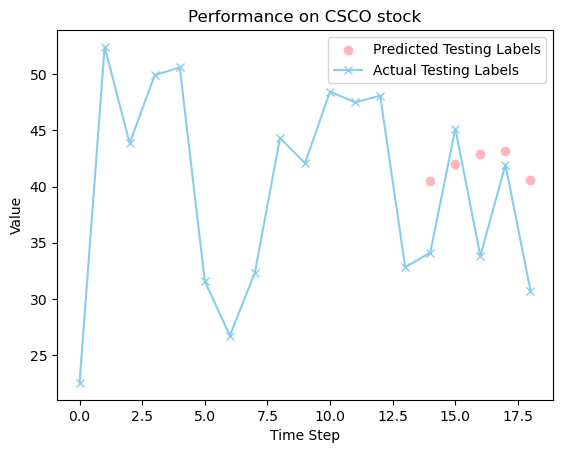

sample  5 :  GOOGL
Epoch 2000: Loss = 23203.6973
Epoch 4000: Loss = 21569.4043
Epoch 6000: Loss = 21502.9199
Epoch 8000: Loss = 22166.9707
Epoch 10000: Loss = 21686.1973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 86347.5391
Test Loss: 86347.5390625
true increase: 0%
true decrease: 40%
false increase: 0%
false decrease: 60%



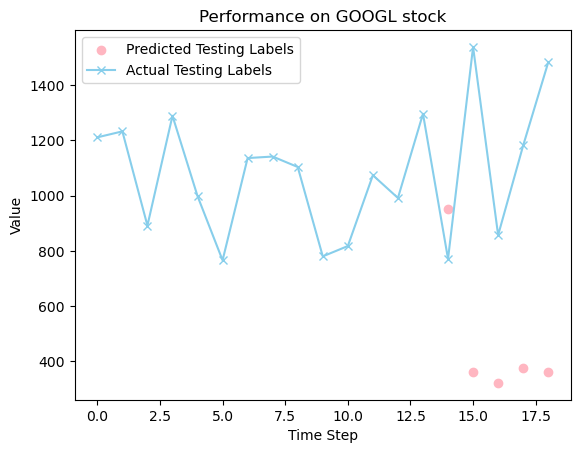

sample  6 :  INTC
Epoch 2000: Loss = 74.7464
Epoch 4000: Loss = 75.4954
Epoch 6000: Loss = 68.7234
Epoch 8000: Loss = 72.7644
Epoch 10000: Loss = 70.7894
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 145.4074
Test Loss: 145.4074249267578
true increase: 0%
true decrease: 60%
false increase: 0%
false decrease: 40%



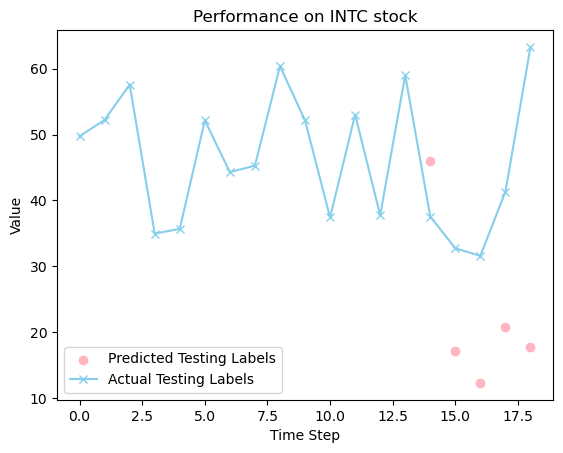

sample  7 :  MSFT
Epoch 2000: Loss = 2118.0913
Epoch 4000: Loss = 2100.5134
Epoch 6000: Loss = 2099.6506
Epoch 8000: Loss = 2105.6111
Epoch 10000: Loss = 2102.0859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1799.8916
Test Loss: 1799.8916015625
true increase: 20%
true decrease: 60%
false increase: 0%
false decrease: 20%



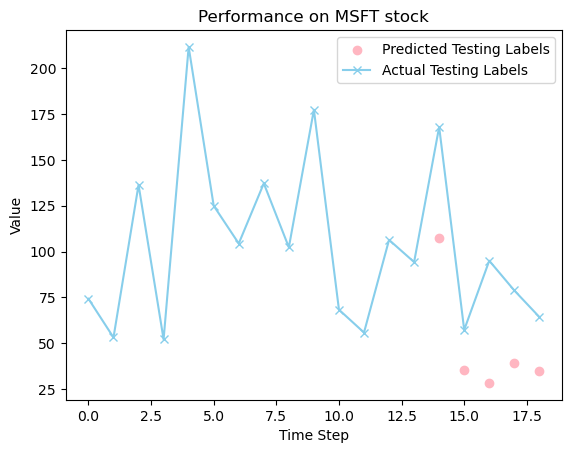

sample  8 :  NVDA
Epoch 2000: Loss = 12554.5469
Epoch 4000: Loss = 12576.9775
Epoch 6000: Loss = 12556.4141
Epoch 8000: Loss = 12580.7783
Epoch 10000: Loss = 12568.4424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 10916.1572
Test Loss: 10916.1572265625
true increase: 0%
true decrease: 60%
false increase: 0%
false decrease: 40%



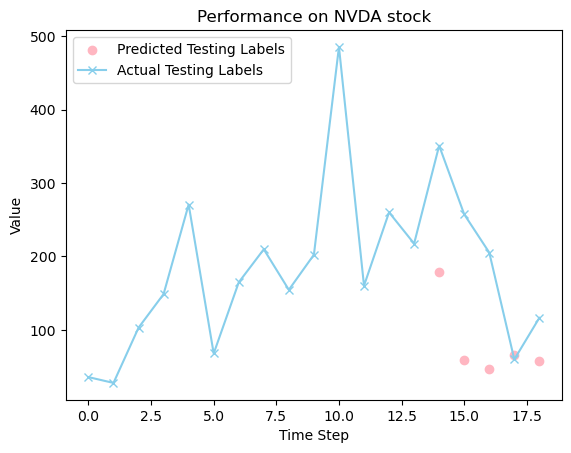

tps 0.2
tns 0.4666666666666667
fps 0.044444444444444446
fns 0.2888888888888889


In [6]:
# Create the LSTM model
model = Sequential([
    LSTM(128, input_shape=(1, 21), kernel_initializer='random_normal'),
    Dense(64, activation='relu', kernel_initializer='random_normal'),
    Dense(1)
])
model.save_weights('model/init_keras_model.weights.h5')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

companies = ['AAPL', 'AMD', 'AMZN', 'ASML','CSCO', 'GOOGL', 'INTC', 'MSFT', 'NVDA']
bi_record = {'tps':[], 'tns':[], 'fps':[], 'fns':[]}

for i in range(9):
    print("sample ", i, ": ", companies[i])
    try:
        model.load_weights('model/'+companies[i]+'_keras_model.weights.h5')
    except:
        model.load_weights('model/init_keras_model.weights.h5')
    model.compile(optimizer='adam', loss='mean_squared_error')

    X = dfs[i].to_numpy()  # Random data simulating your setup
    Y = labels[i].to_numpy()   # Random target values

    # Splitting the data into train and test sets
    X_train, X_test = X[:train_length], X[train_length:]
    Y_train, Y_test = Y[:train_length], Y[train_length:]

    # Reshape input to be [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Fit the model
    model.fit(X_train, Y_train, epochs=n_epochs, batch_size=1, verbose=0,
        callbacks=[CustomPrintCallback(print_every=n_epochs//5)]) 
    
    # Evaluate the model
    test_loss = model.evaluate(X_test, Y_test)
    print(f'Test Loss: {test_loss}')
    
    test_predictions = []
    current_batch = X_test[0].reshape((1, 1, 21))  # Start with the last point in the training set

    for k in range(len(X_test)):
        # Predict one time step and get the result
        current_pred = model.predict(current_batch,verbose=None)[0]
        
        # Store the prediction
        test_predictions.append(current_pred)
        
        # Update the batch to include the new prediction and drop the oldest prediction
        current_batch = np.append(current_batch[:, :, 1:], [[[Y_test[k]]]], axis=2)

    # Convert predictions list to an array for easier handling
    test_predictions = np.array(test_predictions).T[0]
    tp, tn, fp, fn = show_test_performance(np.concatenate((Y_train, test_predictions), axis=0), Y, companies[i])
    bi_record['tps'].append(tp)
    bi_record['tns'].append(tn)
    bi_record['fps'].append(fp)
    bi_record['fns'].append(fn)

    # save model
    model.save_weights('model/'+companies[i]+'_keras_model.weights.h5')

for key in bi_record:
    score = np.array(bi_record[key]).mean()
    print(key, score)


In [7]:
# from tqdm import tqdm
# l_test_predictions, l_Y_test = [], []
# for i in tqdm(range(1)):
#     X = dfs[i].to_numpy()  # Random data simulating your setup
#     Y = labels[i].to_numpy()   # Random target values

#     # Splitting the data into train and test sets
#     X_train, X_test = X[:15], X[:]
#     Y_train, Y_test = Y[:15], Y[:]

#     # Reshape input to be [samples, time steps, features]
#     X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
#     X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

#     test_predictions = []
#     current_batch = X_train[-1].reshape((1, 1, 21))  # Start with the last point in the training set

#     for _ in range(len(X_test)):
#         # Predict one time step and get the result
#         current_pred = model.predict(current_batch,verbose=None)[0]
        
#         # Store the prediction
#         test_predictions.append(current_pred)
        
#         # Update the batch to include the new prediction and drop the oldest prediction
#         current_batch = np.append(current_batch[:, :, 1:], [[current_pred]], axis=2)

#     # Convert predictions list to an array for easier handling
#     test_predictions = np.array(test_predictions).T

#     l_test_predictions.append(test_predictions[0])
#     l_Y_test.append(Y_test)
# l_test_predictions[0], l_Y_test[0]